# Single region analysis

This notebook provides an example of a full processing and analysis pipeline for a single region dataset.

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import numpy as np
import pandas as pd
from IPython.utils import io
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from fileops import *
from parsers import *
from stackers import stack_tifs
from viewers import view_stack
from filters import KalmanDenoiser, NoFilter
from interpolators import StackInterpolator, NoInterpolator
from s2putils import *
from postpro import *
from plotters import *
from utils import *

# Logger level
logger.setLevel(logging.INFO)

## Parameters

### Input & output directories

In [3]:
dataroot = get_data_root()  # Root directory for raw data
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')  # Directory for output figures
logger.info(f'input data root: "{dataroot}"')
logger.info(f'output figures directory: "{figsdir}"')
figs = {}  # Figures dictionary

 23/05/2022 11:48:45: input data root: "/Users/tlemaire/Documents/data/usnm/raw"
 23/05/2022 11:48:45: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs/"


### Input dataset and main processing parameters

In [4]:
mouseline = 'line3'  # mouse line
mouseid = 'mouse12'  # mouse number
region = 'region1'  # brain region
expdate = '11122019'  # experiment date
no_slack_notify = True
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation 
ykey_postpro = Label.DFF  # Reference variable for post-processing  

In [5]:
# Extract input data directory 
datadir = os.path.join(dataroot, mouseline, expdate, mouseid, region)
logger.info(f'input data directory: "{datadir}"')

# Extract figures prefix
figsprefix = f'{mouseline}{mouseid}{region}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{mouseid} {region} notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if not no_slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 23/05/2022 11:48:45: input data directory: "/Users/tlemaire/Documents/data/usnm/raw/line3/11122019/mouse12/region1"
 23/05/2022 11:48:45: mouse12 region1 notebook started on 2022-05-23 at 11:48:45


### Input summary table figure

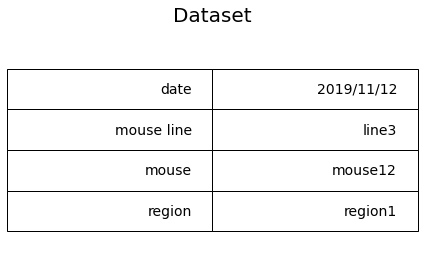

In [6]:
figs['dataset_info'] = plot_table({
    'date': f'{expdate[4:]}/{expdate[:2]}/{expdate[2:4]}',
    'mouse line': mouseline,
    'mouse': mouseid,
    'region': region
    })

### Intermediate data inspection

In [7]:
irun_inspect = None  # run index
nROIs_inspect = 3  # number of ROIs to look at for the inspection run (if specified)
irun_eq = 4  # equivalent run index from suite2p output 
stacktitle = f'run {irun_inspect}'  # default stack title
stackdict = None  # empty stacks dictionary
runbounds = None  # empty runbounds array
istimframes_stacked = None  # empty stimulus frames array
save_gifs = False  # whether to save gifs of extracted movies or not

## Pre-processing (stacking, substitution, denoising)

### Gather data folders & extract acquisition settings

In [8]:
# Get raw list of subolders containing tifs
tif_folders = get_data_folders(datadir, exclude_patterns=['MIP', 'References', 'incomplete'], include_patterns=[mouseline])
tif_folders_str = '\n'.join([f'  - {os.path.basename(x)}' for x in tif_folders])
logger.info(f'Identified folders containing TIF files:\n{tif_folders_str}')

# Extract acquisition settings from each run
logger.info('extracting aquisition settings...')
daq_settings = parse_aquisition_settings(tif_folders)
daq_settings

 23/05/2022 11:48:45: /Users/tlemaire/Documents/data/usnm/raw/line3/11122019/mouse12/region1
 23/05/2022 11:48:46: Identified folders containing TIF files:
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860
  - line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862
  - line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-861
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-858
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_80DC-863
  - line3_100frames_100Hz_200ms_3.56Hz_01MPA_50DC-867
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-857
  - line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-868
  - line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-864
  - line3_100frames_100Hz_200ms_3.56Hz_08MPA_10DC-859
  - line3_100frames_100Hz_200ms_3.56Hz_02MPA_50DC-866
 23/05/2022 11:48:46: extracting 

{'activeMode': 'Galvo',
 'bitDepth': 12.0,
 'currentScanAmplitude': {'XAxis': 7.6, 'YAxis': -7.6},
 'currentScanCenter': {'XAxis': 0.0, 'YAxis': 0.0},
 'daq': ('10x', 'Gain10'),
 'dwellTime': 2.8,
 'framePeriod': 0.280453201144955,
 'interlacedScanTrackCount': 0.0,
 'laserPower': (311.0, 'Pockels'),
 'laserWavelength': (920.0, 'Insight'),
 'linesPerFrame': 256.0,
 'maxVoltage': {'XAxis': 3.19540637796412, 'YAxis': -3.19540637796412},
 'micronsPerPixel': 1.96865654688785,
 'minVoltage': {'XAxis': -3.19540637796412, 'YAxis': 3.19540637796412},
 'objectiveLens': 'Olympus 10X',
 'objectiveLensMag': 10.0,
 'objectiveLensNA': 1.0,
 'opticalZoom': 2.37841423000544,
 'pixelsPerLine': 256.0,
 'pmtGain': {'PMT 1 HV': 0.0, 'PMT 2 HV': 394.7021276596, 'PMT 3 HV': 0.0},
 'positionCurrent': {'XAxis': 1.11, 'YAxis': 2.06, 'ZAxis': 0.05},
 'preampFilter': ('Filter1250KHz', '1.25 MHz'),
 'preampGain': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'preampOffset': {'Ch1': 0.0, 'Ch2': 0.0, 'Ch3': 0.0},
 'rasters

### Merge TIFs into stack

 23/05/2022 11:48:48: "/Users/tlemaire/Documents/data/usnm/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 23/05/2022 11:48:48: "/Users/tlemaire/Documents/data/usnm/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 23/05/2022 11:48:48: "/Users/tlemaire/Documents/data/usnm/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 23/05/2022 11:48:48: "/Users/tlemaire/Documents/data/usnm/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 23/05/2022 11:48:48: "/Users/tlemaire/Documents/data/usnm/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 23/05/2022 11:48:48: "/Users/tlemaire/Documents/data/usnm/stacked/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_04MPA_50DC-865.tif" already

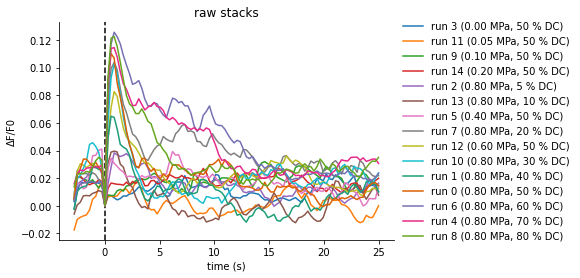

In [9]:
# Generate stacks for all TIF folders in the input data directory
raw_stack_fpaths = []
nframes_per_run = []
for tif_folder in tif_folders:
    with io.capture_output() as captured:  # turning off warning upon TIF reading
        stack_fpath, stack_shape = stack_tifs(tif_folder, overwrite=False, full_output=True)
        raw_stack_fpaths.append(stack_fpath)
        nframes_per_run.append(stack_shape[0])

# Extract number of runs
nruns = len(raw_stack_fpaths)
logger.info(f'number of runs: {nruns}')

# Extract and check consistency of number of frames per run
nframes_per_run = list(set(nframes_per_run))
assert len(nframes_per_run) == 1, f'Differing stack lengths: {nframes_per_run}'
nframes_per_run = nframes_per_run[0]
logger.info(f'number of frames per run: {nframes_per_run}')

# Deduce number of trials per run
logger.info(f'number of frames per trial: {NFRAMES_PER_TRIAL}')
ntrials_per_run = nframes_per_run // NFRAMES_PER_TRIAL
logger.info(f'number of trials per run: {ntrials_per_run}')

figs['trialavg_stackavg_traces raw'] = plot_trialavg_stackavg_traces(
    raw_stack_fpaths, ntrials_per_run, title='raw stacks')

# Define indexes of stimulation frames for a run
i_stim_frames_run = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load stack
    raw_stack = loadtif(raw_stack_fpaths[irun_inspect])

    # Plot stack summary frames
    figs[f'raw_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        raw_stack, title=f'run {irun_inspect} - raw stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'raw_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack}, title=f'run {irun_inspect} - raw stack')

    # Plot stack frequency spectrum
    figs[f'raw_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw': raw_stack},  1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - raw stack')

    # Plot time course of the stack spatial average
    figs[f'raw_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        {'raw': raw_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - raw stack')

    # View stack
    stackdict = {'raw': raw_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run)

### Substitute stimulation frames

Since stimulation frames are highly polluted by stimulation-evoked noise, we substitute them by artificial frames estimated via spline interpolation of the preceding baseline frames.

For now, we only perform a zero order interpolation, meaning that the preceding frame use use as the estimate of the stimulus frame

 23/05/2022 11:48:53: "/Users/tlemaire/Documents/data/usnm/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 23/05/2022 11:48:53: "/Users/tlemaire/Documents/data/usnm/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 23/05/2022 11:48:53: "/Users/tlemaire/Documents/data/usnm/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 23/05/2022 11:48:53: "/Users/tlemaire/Documents/data/usnm/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 23/05/2022 11:48:53: "/Users/tlemaire/Documents/data/usnm/interpolated/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_70DC-862.tif" already exists
 23/05/2022 11:48:53: "/Users/tlemaire/Documents/d

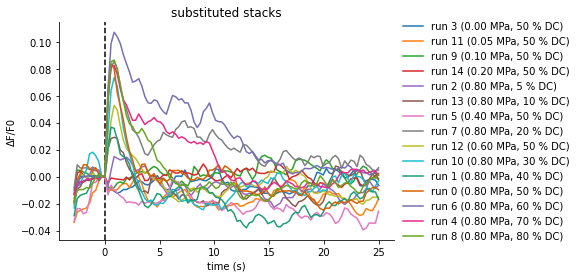

In [10]:
# Define interpolator object
si = StackInterpolator(order=0, npast=2)

# Substitute stim frames every TIF stack and save outputs in specific directory 
input_root = 'stacked'
substituted_stack_fpaths = process_and_save(
    si, raw_stack_fpaths, input_root, i_stim_frames_run, overwrite=False)

figs['trialavg_stackavg_traces substituted'] = plot_trialavg_stackavg_traces(
    substituted_stack_fpaths, ntrials_per_run, title='substituted stacks')

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load interpolated stack for the same run
    subsituted_stack = loadtif(substituted_stack_fpaths[irun_inspect])

    # Plot interpolated stack summary frames
    figs[f'interp_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        subsituted_stack, title=f'run {irun_inspect} - {si} substituted stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot stack histogram
    figs[f'interp_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw': raw_stack, 'substituted': subsituted_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'interp_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw': raw_stack, 'substituted': subsituted_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'interp_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw': raw_stack_fpaths[irun_inspect],
        'substituted': substituted_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw and inteprolated stacks side-by-side
    stackdict = {
        'raw': raw_stack_fpaths[irun_inspect],
        si: substituted_stack_fpaths[irun_inspect]}

view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

### Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

 23/05/2022 11:48:56: "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-855.tif" already exists
 23/05/2022 11:48:56: "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_40DC-856.tif" already exists
 23/05/2022 11:48:56: "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-860.tif" already exists
 23/05/2022 11:48:56: "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_00MPA_50DC-869.tif" already exists
 23/05/2022 11:48:56: "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/line3_100frames_100Hz_200ms_3.56Hz_

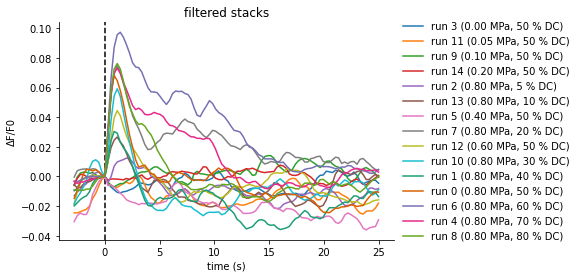

In [11]:
# Define Kalman filter
if kalman_gain is not None and kalman_gain > 0:
    kd = KalmanDenoiser(G=kalman_gain, V=0.05, npad=10)  # real filter object
else:
    kd = NoFilter()  # dummy filter object used to work on raw stacks

# Denoise every TIF stack and save outputs in specific directory
input_root = 'stacked' if isinstance(si, NoInterpolator) else si.rootcode
filtered_stack_fpaths = process_and_save(kd, substituted_stack_fpaths, input_root, overwrite=False)

figs['trialavg_stackavg_traces filtered'] = plot_trialavg_stackavg_traces(
    filtered_stack_fpaths, ntrials_per_run, title='filtered stacks')

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:
    # Load denoised stack for the same run
    filtered_stack = loadtif(filtered_stack_fpaths[irun_inspect])

    # Plot denoised stack summary frames
    figs[f'filtered_stack_frames_run{irun_inspect}'] = plot_stack_summary_frames(
        filtered_stack, title=f'run {irun_inspect} - {kd} filtered stack',
        um_per_px=daq_settings['micronsPerPixel'])

    # Plot comparative stack histograms
    figs[f'filtered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
        title=f'run {irun_inspect} - stacks comparison')

    # Plot stack frequency spectrum
    figs[f'filtered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
            {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack},
            1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    figs[f'filtered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        }, ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')

    # Visualize raw, inteprolated and denoised stacks side-by-side
    stackdict = {
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        kd: filtered_stack_fpaths[irun_inspect]}
    
view_stack(stackdict, title=stacktitle, ilabels=i_stim_frames_run, norm=True)

## Functional segmentation (suite2p)

 23/05/2022 11:49:00: parsed frame rate = 3.56 fps
 23/05/2022 11:49:00: Suite2p input directory:
/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1
 23/05/2022 11:49:00: running suite2p 0.10.2 with the following options:
{'denoise': False,
 'do_registration': 1,
 'fs': 3.56,
 'nonrigid': True,
 'reg_tif': True,
 'tau': 1.25}
 23/05/2022 11:49:00: data will be saved in suite2p base directory "suite2p_fs_3.56_reg_tif_tau_1.25"
 23/05/2022 11:49:00: found all suite2p output files in "/Users/tlemaire/Documents/data/usnm/filtered/kd_G0.5_V0.05_npad10/si_order0_npast2/line3/11122019/mouse12/region1/suite2p_fs_3.56_reg_tif_tau_1.25/plane0"
 23/05/2022 11:49:00: run options match 100% -> ignoring
 23/05/2022 11:49:00: empty data path -> no run
 23/05/2022 11:49:00: extracted data contains 880 ROIs
 23/05/2022 11:49:00: zero pressure run index = 0
 23/05/2022 11:49:00: output info table corresponding to suite2p processing order:
  

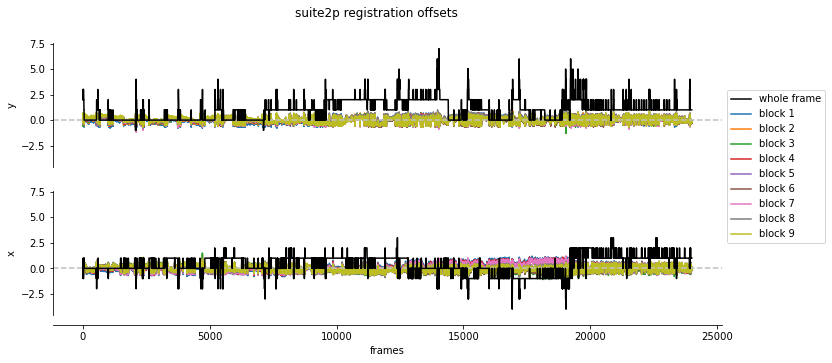

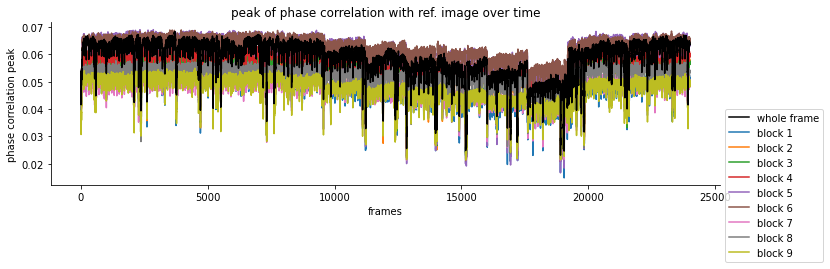

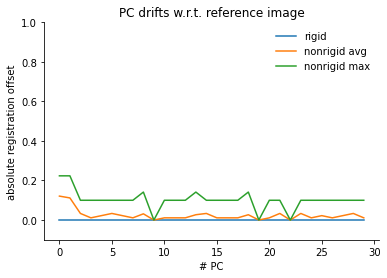

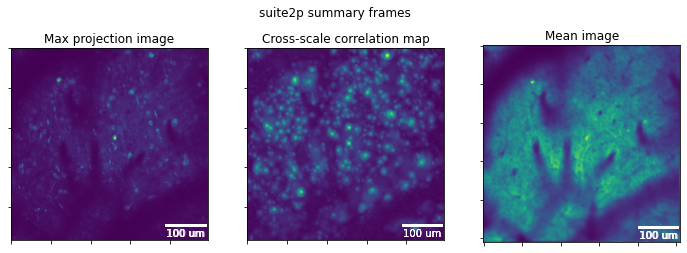

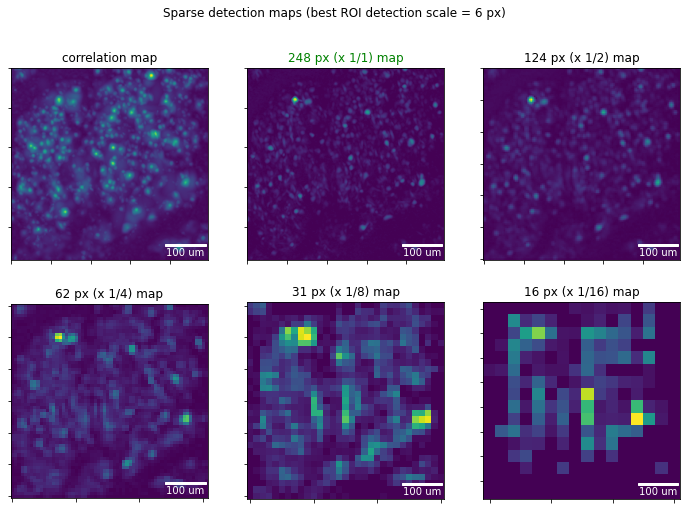

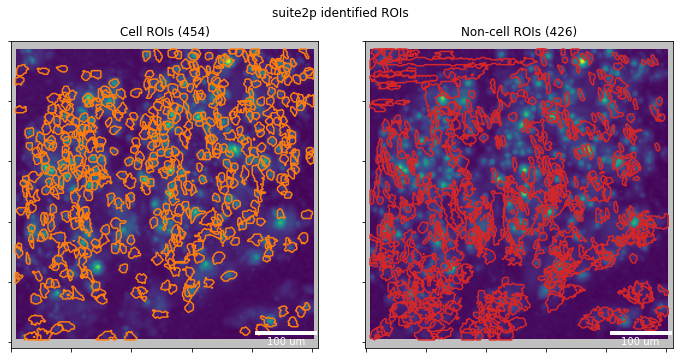

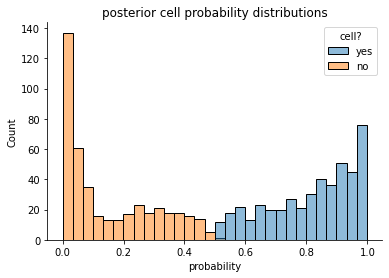

In [12]:
# Determine input filepaths (filtered stacks)
s2p_input_fpaths = filtered_stack_fpaths

# Parse input files into info table and extract FPS from it
input_info_table = get_info_table(s2p_input_fpaths, ntrials_per_run=ntrials_per_run)
fps = get_singleton(input_info_table, Label.FPS)
logger.info(f'parsed frame rate = {fps} fps')

# Get the list of folders containing the input filepaths
# For now, limit ourselves to 1 folder at a time
s2p_input_dirs = list(set(os.path.split(x)[0] for x in s2p_input_fpaths))
assert len(s2p_input_dirs) == 1, 'More than 1 suite2p input directory'
s2p_input_dir = s2p_input_dirs[0]
logger.info(f'Suite2p input directory:\n{s2p_input_dir}')

# Define suite2p custom options
ops = {
    'tau': TAU_GCAMP6S_DECAY,  # timescale of the sensor
    'fs': fps,  # sampling rate (per plane)
    'do_registration': 1,  # whether or not to perform image registration,
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': False,  # perform PCA denoising of the registered stack prior to ROI detection
}

# Run suite2p with custom options
s2p_basedir = run_s2p_and_rename(
    ops=ops, db={'data_path': s2p_input_dirs}, overwrite='?')

# Load suite2p output data and extract options dictionary
s2p_output_fpath = os.path.join(s2p_input_dirs[0], s2p_basedir, 'plane0')
s2p_data = get_suite2p_data(s2p_output_fpath, withops=True, s2p_basedir=s2p_basedir)
s2p_ops = s2p_data.pop('ops')
outstack_label = get_s2p_stack_label(s2p_ops)

# Check that number of runs and number of frames per run extracted from suite2p output
# are consistent with suite2p inputs
nruns_out = len(s2p_ops['filelist'])
assert nruns == nruns_out, f'inconsistent number of runs between input and output: {nruns} and {nruns_out}'
del nruns_out
nframes_per_run_out = list(set(s2p_ops['frames_per_file']))
assert len(nframes_per_run_out) == 1,  'inconsistent number of frames for each run in output'
nframes_per_run_out = nframes_per_run_out[0]
assert nframes_per_run == nframes_per_run_out, f'inconsistent number of frames per run between input and output: {nframes_per_run} and {nframes_per_run_out}'
del nframes_per_run_out

# Generate info table from suite2p output, and map suite2p processed file indexes
# with input files indexes (for comparative plotting purposes)
output_info_table = get_info_table(s2p_ops['filelist'], ntrials_per_run=ntrials_per_run)
output_to_input_mapping = (output_info_table['code'].values[:, None] == input_info_table['code'].values).argmax(axis=0)
del output_info_table['code']

# Get index of zero pressure run
irun_P0 = output_info_table[output_info_table[Label.P] == 0.].index[0]
logger.info(f'zero pressure run index = {irun_P0}')

# Log info table
logger.info(
    f'output info table corresponding to suite2p processing order:\n{output_info_table}')

# If run index is defined, inspect stack metrics for that particular run
if irun_inspect is not None:

    # View output stack
    istimframes_stacked = np.tile(i_stim_frames_run, (nruns, 1))
    for i in range(nruns):
        istimframes_stacked[i] += i * nframes_per_run
    istimframes_stacked = istimframes_stacked.flatten()
    irun_eq = output_to_input_mapping[irun_inspect]
    runbounds = [nframes_per_run * irun_eq, nframes_per_run * (irun_eq + 1) - 1]
    stackdict = s2p_ops
    stacktitle = f'{outstack_label} stack (run {irun_inspect} -> output {irun_eq})'
    registered_stack = get_s2p_stack(s2p_ops, bounds=runbounds)

    # Plot stack histogram
    figs[f'registered_stack_hist_run{irun_inspect}'] = plot_stack_histogram(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        title=f'run {irun_inspect} - stacks comparison')
    
    # Plot stack frequency spectrum
    figs[f'registered_stack_fspectrum_run{irun_inspect}'] = plot_stack_frequency_spectrum(
        {'raw (substituted)': subsituted_stack, 'filtered': filtered_stack, outstack_label: registered_stack},
        1 / daq_settings['framePeriod'], title=f'run {irun_inspect} - stacks comparison')

    # Plot comparative time course of the stacks spatial average
    # That is a good opportunity to check that our mapping of input stacks
    # to suite2p output stacks is correct.
    fig = plot_stack_timecourse({
        'raw (substituted)': substituted_stack_fpaths[irun_inspect],
        'filtered': filtered_stack_fpaths[irun_inspect]
        },
        ilabels=i_stim_frames_run, title=f'run {irun_inspect} - stacks comparison')
    figs[f'registered_stack_timecourse_run{irun_inspect}'] = plot_stack_timecourse(
        s2p_ops, title=outstack_label, bounds=runbounds, ax=fig.axes[0])

# Plot registration offsets over time
figs['registered_offsets'] = plot_suite2p_registration_offsets(
    s2p_ops, title='suite2p registration offsets')

# Plot registration quality metrics (phase correlation peak & PC drifts)
figs['phasecorrpeak_over_time'] = plot_suite2p_phase_corr_peak(s2p_ops)
figs['PCdrifts'] = plot_suite2p_PC_drifts(s2p_ops)

# Plot suite2p summary images
figs['registered_images'] = plot_suite2p_registration_images(
    s2p_ops, title='suite2p summary frames', um_per_px=daq_settings['micronsPerPixel'])

# Plot sparse detection maps
figs['sparse_maps'] = plot_suite2p_sparse_maps(
    s2p_ops, um_per_px=daq_settings['micronsPerPixel'])

# Plot detected ROIs on FOV
figs['identified_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='suite2p identified ROIs',
    um_per_px=daq_settings['micronsPerPixel'], mode='contour')

# Plot posterior cell probabilities for all ROIs 
figs['ROI_prob_dists'] = plot_suite2p_ROI_probs(s2p_data['iscell'])

view_stack(stackdict, title=stacktitle, bounds=runbounds, ilabels=istimframes_stacked)

## Post-processing: from raw F traces to ΔF/F and Z(ΔF/F) traces

### Load processed data if available

In [18]:
baseline_str = f'w{baseline_wlen:.1f}s' if baseline_wlen is not None else ''
postpro_str = f'{baseline_str}_q{baseline_quantile:.2f}'
postpro_root_key = input_root if isinstance(kd, NoFilter) else 'filtered'
postpro_root = get_output_equivalent(
    s2p_input_dir, postpro_root_key, 'processed', mkdirs=False)
postpro_root, *postpro_subdirs = split_path_at(postpro_root, mouseline)
postpro_outdir = os.path.join(postpro_root, postpro_str, *postpro_subdirs)
is_postpro_data_available = check_timeseries_data(postpro_outdir, nruns)
if is_postpro_data_available:
    logger.info('loading data...')
    xtimeseries, output_info_table, ROI_masks = load_timeseries_data(postpro_outdir, nruns)
    logger.info(f'experiment info table:\n{output_info_table}')
    logger.info(f'processed timeseries: {describe_dataframe_index(xtimeseries)} dataframe')
    logger.info(f'ROI masks: {describe_dataframe_index(ROI_masks)} dataframe')

 23/05/2022 11:52:59: processed timeseries data is available in "/Users/tlemaire/Documents/data/usnm/processed/kd_G0.5_V0.05_npad10/si_order0_npast2/w5.0s_q0.08/line3/11122019/mouse12/region1" directory
 23/05/2022 11:52:59: loading data...
 23/05/2022 11:52:59: loading experiment info table...
 23/05/2022 11:52:59: loading processed timeseries data for 15 runs...


100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


 23/05/2022 11:53:04: re-organizing timeseries index...
 23/05/2022 11:53:08: loading ROI masks...
 23/05/2022 11:53:08: data successfully loaded
 23/05/2022 11:53:08: experiment info table:
      line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  ntrials
run                                                                           
0    line3           100           0.2  3.56     0.00    50.0     869       16
1    line3           100           0.2  3.56     0.10    50.0     867       16
2    line3           100           0.2  3.56     0.20    50.0     866       16
3    line3           100           0.2  3.56     0.40    50.0     865       16
4    line3           100           0.2  3.56     0.05    50.0     868       16
5    line3           100           0.2  3.56     0.60    50.0     864       16
6    line3           100           0.2  3.56     0.80     5.0     860       16
7    line3           100           0.2  3.56     0.80    10.0     859       16
8    line3         

### Get fluorescence timeseries data

In [19]:
%%skip $is_postpro_data_available

# Get fluorescence timeseries
raw_timeseries = arrays_to_dataframe({
    Label.F_ROI: s2p_data['F'],
    Label.F_NEU: s2p_data['Fneu']},
    dim_names=[Label.ROI, Label.FRAME])
logger.info(f'assembled ({describe_dataframe_index(raw_timeseries)}) fluorescence timeseries dataframe')

# Split the data into separate runs
run_delimiters = np.arange(nruns + 1) * nframes_per_run
raw_timeseries = separate_runs(raw_timeseries, nruns)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Split the data into separate trials
stim_delimiters = np.arange(ntrials_per_run) * NFRAMES_PER_TRIAL + FrameIndex.STIM
raw_timeseries = separate_trials(raw_timeseries, ntrials_per_run)
logger.info(f'reshaped dataframe into ({describe_dataframe_index(raw_timeseries)}) form')

# Add time to table
raw_timeseries[Label.FPS] = fps
add_time_to_table(raw_timeseries)

# Filter out non-cell ROIs
logger.info('discarding non-cell ROIs...')
iscell = s2p_data['iscell'][:, 0]
icells = np.flatnonzero(iscell)
raw_timeseries = raw_timeseries.loc[(icells)]
s2p_data = filter_s2p_data(s2p_data, icells)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Discard outliers based on morphological properties (if specified)
from constants import NPIX_RATIO_THR
if NPIX_RATIO_THR is not None:
    # Plot ratio of (# pixels in the whole ROI) / (# pixels in its soma) for each ROI
    # and identify outlier ROIs
    logger.info('identifying outliers based on # pixels ratio...')
    figs['npix_ratio'], df_outliers = plot_npix_ratio_distribution(
        s2p_data['stat'], thr=NPIX_RATIO_THR)
    df_outliers[Label.ROI] = icells
    df_outliers = df_outliers.set_index(Label.ROI)
    ioutliers = np.flatnonzero(df_outliers['is_outlier'])

    # Discard outliers from data
    logger.info('updating dataset...')
    ivalids = np.flatnonzero(~df_outliers['is_outlier'])
    raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index)]
    s2p_data = filter_s2p_data(s2p_data, ivalids)
    logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

    # Plot filtered ROIs map
    figs['filtered_ROIs'] = plot_suite2p_ROIs(
        s2p_data, s2p_ops, title='filtered suite2p ROIs',
        um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

    # Log identified outliers
    logger.info(f'identified {len(ioutliers)} outlier(s):')
    df_outliers.iloc[ioutliers]

# Extract max F_ROI value of each ROI across time
F_ROI_max = raw_timeseries[Label.F_ROI].groupby(Label.ROI).max().rename(Label.MAX_F_ROI)
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Identify invalid ROIs with zero F_ROI range 
df_invalids = F_ROI_max.to_frame()
df_invalids['is_invalid'] = F_ROI_max == 0
iinvalids = np.flatnonzero(df_invalids['is_invalid'])

# Plot histogram distribution of max F_ROI across ROIs
fig, ax = plt.subplots()
ax.set_title(f'max {Label.F_ROI} distribution across ROIs')
sns.despine(ax=ax)
sns.histplot(df_invalids, x=Label.MAX_F_ROI, hue='is_invalid', bins=50, ax=ax)

# Discard invalid ROIs from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_invalids['is_invalid'])
raw_timeseries = raw_timeseries.loc[(df_invalids.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence timeseries dataframe')

# Plot filtered ROIs map
figs['filtered_ROIs'] = plot_suite2p_ROIs(
    s2p_data, s2p_ops, title='filtered suite2p ROIs',
    um_per_px=daq_settings['micronsPerPixel'], superimpose=True)

# Plot fluorescence traces for all selected ROIs 
figs['F_ROI_traces_allROIs'] = plot_ROIs(raw_timeseries, Label.F_ROI)

# Plot aggregate traces
figs[f'{Label.F_ROI} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F_ROI, Label.F_NEU], itrial=slice(1, 16))

# Log identified invalids
logger.info(f'identified {len(iinvalids)} invalid ROI(s):')
df_invalids.iloc[iinvalids]

# Select subset of ROIs to plot
iROIs = raw_timeseries.index.unique(level=Label.ROI)
if nROIs_inspect > 0:
    iROI_inspect = np.random.choice(iROIs, size=nROIs_inspect)
    iROI_inspect.sort()  # sort ROIs subset to ensure consistent looping
    logger.info(f'randomly selecting {len(iROI_inspect)} ROI(s) for plotting (index(es) = {iROI_inspect})')

    # Plot longitudinal fluorescence traces for selected ROI
    figs['raw_F_traces'] = plot_traces(
        raw_timeseries[[Label.F_ROI, Label.F_NEU]], ylabel=Label.F,
        iROI=iROI_inspect, delimiters=run_delimiters)

### Compute neuropil-corrected fluorescence data

In [20]:
%%skip $is_postpro_data_available

# Compute ROI-specific neuropil coefficients minimizing specific cost function
from constants import ALPHA
nROIs = len(raw_timeseries.index.unique(Label.ROI))
costfunc = force_positive_Fc(center_around(ALPHA))
alpha_bounds = (0.2, 2)
logger.info(f'computing alphas minimizing {costfunc.__name__} function within {alpha_bounds} interval...')
with tqdm(total=nROIs - 1, position=0, leave=True) as pbar:
    alphas = raw_timeseries.groupby(Label.ROI).apply(
        pbar_update(lambda x: optimize_alpha(x, costfunc, bounds=alpha_bounds), pbar))
alphas = alphas.rename(Label.ALPHA)

# Plot resulting distribution of neuropil subtraction coefficients
figs['alphas'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('distribution of optimal alphas across ROIs')
sns.violinplot(data=alphas.to_frame(), y=Label.ALPHA, ax=ax)
ax.set_ylim(0., 1.)

# Subtract neuropil background fluorescence for each ROI of interest
logger.info(f'subtracting neuropil background...')
raw_timeseries[Label.F] = raw_timeseries[Label.F_ROI] - alphas * raw_timeseries[Label.F_NEU]

# Plot corrected fluorescence for all ROIs
figs['F_traces_allROIs'] = plot_ROIs(raw_timeseries, Label.F)

# Plot aggregate traces
figs[f'{Label.F} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.F, hue=Label.RUN, itrial=slice(1, 16), stim_correct=True)

if nROIs_inspect > 0:
    # Plot longitudinal fluorescence traces for selected ROI
    alphas_plt = alphas.loc[iROI_inspect].groupby(Label.ROI).first()
    figs['F_trace'] = plot_traces(
        raw_timeseries[[Label.F]],
        iROI=iROI_inspect, delimiters=run_delimiters,
        title=[f'{Label.ALPHA} = {a:.2f}' for a in alphas_plt])
    if irun_eq is not None:
        # Highlight selected run on figure
        for ax in figs['F_trace'].axes:
            ax.axvspan(run_delimiters[irun_eq], run_delimiters[irun_eq + 1], color='silver', alpha=0.5)

### Baseline computation & correction

The baseline of fluorescence signals is computed by applying consecutively (1) a low percentile sliding window and (2) an average sliding window, over the entire fluorescence timecourse. This is performed independently for each cell (obviously) but also for each run owing to potential discontinuities in acquisition conditions across runs (especially since the stacking order of these runs does not necessarily follow the original chronological order of acquisition).

For downstream analysis steps, we wish to consider only cells who exhibit a relatively flat activity baseline. Therefore, at this point we discard any cell whose baseline fluctuations are above a certain threshold. Since baseline fluorescence levels vary significantly across cells, we use a relative metrics (relative standard deviation RSD) to evaluate fluctuations of the baseline around its mean, and discard cells whose baseline RSD is above some defined threshold for any of the acquisition runs.

The remaining fluorescence signals are corrected by subtraction of a mean-corrected time-varying baseline.

In [21]:
%%skip $is_postpro_data_available

# Compute F baseline
raw_timeseries[Label.F0] = compute_baseline(
    raw_timeseries[Label.F], fps, baseline_wlen, baseline_quantile, smooth=True)

# Plot original and baseline fluorescence of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    title = f'q = {baseline_quantile * 1e2:.1f} %'
    if baseline_wlen is not None:
        title = f'w = {baseline_wlen:.1f} s, {title}'
    figs[f'F_F0_trace_run{irun_inspect}'] = plot_traces(
        raw_timeseries[[Label.F, Label.F0]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters, title=title)

# Compute F0 relative standard deviation for each ROI and run
logger.info('computing baseline relative standard deviation...')
F0_RSD_per_run = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).agg(
    lambda x: np.nanstd(x) / np.abs(np.nanmean(x)))

# Identify outliers as ROIs whose max RSD across runs is above defined threshold
logger.info('identifying outliers...')
F0_RSD_max = F0_RSD_per_run.groupby(Label.ROI).max()
is_outlier = (F0_RSD_max > BASELINE_RSD_THR)
df_outliers = pd.DataFrame({'max F0 RSD': F0_RSD_max, 'is_outlier': is_outlier})
ioutliers = np.flatnonzero(df_outliers['is_outlier'])

# Plot RSD distribution per ROI & run amongst remaining ROIs
fig, ax = plt.subplots()
sns.heatmap(
    F0_RSD_per_run.drop(df_outliers.iloc[ioutliers].index).unstack(),
    vmin=0, cmap='viridis', ax=ax)
ax.set_title('F0 RSD distribution per ROI & run')

# Discard outliers from data
logger.info('updating dataset...')
ivalids = np.flatnonzero(~df_outliers['is_outlier'])
raw_timeseries = raw_timeseries.loc[(df_outliers.iloc[ivalids].index)]
s2p_data = filter_s2p_data(s2p_data, ivalids)
logger.info(f'filtered to {describe_dataframe_index(raw_timeseries)} fluorescence dataframe')

# Apply mean correction to remaining fluorescence and baseline signals
logger.info('subtracting mean-corrected baseline from signals for each ROI & run...')
F0_mean = raw_timeseries[Label.F0].groupby([Label.ROI, Label.RUN]).mean()
F0_mean_exp = expand_to_match(F0_mean, raw_timeseries.index)
# Apply baseline corretor to both fluorescence and baseline signals
detrender = raw_timeseries[Label.F0] - F0_mean_exp
raw_timeseries[Label.F_DETRENDED] = raw_timeseries[Label.F] - detrender
raw_timeseries[Label.F0_DETRENDED] = raw_timeseries[Label.F0] - detrender

# Plot detrended fluorescence for all ROIs
figs['Ftraces_allROIs_detrended'] = plot_ROIs(raw_timeseries, Label.F_DETRENDED)

# Plot aggregate traces
figs[f'{Label.F_DETRENDED} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, [Label.F, Label.F_DETRENDED], itrial=slice(1, 16), stim_correct=True)

# Compute relative baseline variations over runs
rel_F0_mean = F0_mean - F0_mean.groupby(Label.ROI).min()
rel_F0_mean /= rel_F0_mean.groupby(Label.ROI).max()

# Plot relative baseline variation over runs
figs['relative baseline variation over runs'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('relative variation of fluorescence baseline over runs')
sns.lineplot(data=rel_F0_mean.to_frame(), ax=ax, x=Label.RUN, y=Label.F0)

# Log identified outliers
logger.info(f'identified {len(ioutliers)} outlier(s):')
df_outliers.iloc[ioutliers]

### ΔF/F0 computation

In [22]:
%%skip $is_postpro_data_available

# Compute relative change in fluorescence
logger.info('computing relative change in fluorescence...')
raw_timeseries[Label.DFF] = (
    raw_timeseries[Label.F] - raw_timeseries[Label.F0]) / raw_timeseries[Label.F0_DETRENDED]

# Plot aggregate traces
figs[f'{Label.DFF} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.DFF, hue=Label.RUN, itrial=slice(1, 16), stim_correct=True)

# Plot DFF for all ROIs
nROIs = len(raw_timeseries.index.unique(level=Label.ROI))
figs['DFFtraces_allROIs'] = plot_ROIs(
    raw_timeseries, Label.DFF, ydelimiters=np.zeros(nROIs), stacked=True, ntraces=20)

# Plot consecutive trials of relative fluorescence change of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'dFF_trace_run{irun_inspect}'] = plot_traces(
        raw_timeseries[[Label.DFF]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)

### Z(ΔF/F0) computation

In [23]:
%%skip $is_postpro_data_available

# Fit gaussians to dFF histogram distributions
logger.info('fitting gaussians to dFF histogram distributions...')
groups = raw_timeseries[Label.DFF].groupby([Label.ROI, Label.RUN])
with tqdm(total=groups.ngroups, position=0, leave=True) as pbar:
    dFF_histfits = groups.agg(pbar_update(nan_proof(gauss_histogram_fit), pbar))
nbins = dFF_histfits.iloc[0][0].size
logger.info('extracting fitted gaussian parameters...')
dFF_histparams = dFF_histfits.apply(lambda x: x[1])
dFF_histparams = pd.DataFrame(
    dFF_histparams.tolist(),
    columns=['H', 'A', 'x0', 'sigma'],
    index=dFF_histparams.index)

# Plot distributions of the relevant extracted Gaussian parameters
figs['gaussianfits_dists'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('dFF Gaussian fit parameters distributions')
sns.scatterplot(data=dFF_histparams, x='x0', y='sigma', ax=ax)

# Normalize dFF traces by gaussian parameters to obtain dFF z-scores
logger.info('expanding dFF params to match timeseries index...')
dFF_histparams_exp = expand_to_match(dFF_histparams, raw_timeseries.index)
logger.info('normalizing dFF by gaussian parameters to compute z-scores...')
raw_timeseries[Label.ZSCORE] = (
    raw_timeseries.loc[:, Label.DFF] - dFF_histparams_exp['x0']) / dFF_histparams_exp['sigma']

# Plot aggregate traces
figs[f'{Label.ZSCORE} aggregate traces'] = plot_aggregate_traces(
    raw_timeseries, fps, Label.ZSCORE, hue=Label.RUN, itrial=slice(1, 16), stim_correct=True)

# Plot z-scores for all ROIs with markers at +/- 1
ydelims = np.tile(np.array([-1, 1]), (nROIs, 1))
figs['DFFtraces_allROIs'] = plot_ROIs(
    raw_timeseries, Label.ZSCORE, ydelimiters=ydelims, stacked=True, ntraces=20)

# Plot consecutive trials of dFF z-score of selected ROI for selected run
if nROIs_inspect > 0 and irun_eq is not None:
    figs[f'zscore_trace_run{irun_inspect}'] = plot_traces(
        raw_timeseries[[Label.ZSCORE]],
        iROI=iROI_inspect, irun=irun_eq, delimiters=stim_delimiters)
    for ax in figs[f'zscore_trace_run{irun_inspect}'].axes:
        ax.axhspan(- 1, 1, fc='silver', ec=None, alpha=0.5);

### Save ΔF/F and Z(ΔF/F) traces

In [24]:
%%skip $is_postpro_data_available

# Reduce timeseries data to dff and z-scores only
xtimeseries = raw_timeseries.loc[:, [Label.DFF, Label.ZSCORE]]
# Gather ROI masks information in dataframe
ROI_masks = get_ROI_masks(s2p_data['stat'], xtimeseries.index.unique(level=Label.ROI))
# Save data in output directory
save_timeseries_data(xtimeseries, output_info_table, ROI_masks, postpro_outdir)

### Compute relative ΔF/F and Z(ΔF/F) traces

In [25]:
for ykey in [Label.DFF, Label.ZSCORE]:
    logger.info(f'computing relative traces for {ykey}...')
    rel_ykey = f'{ykey} - {ykey}_stim'
    ystim = xtimeseries.loc[
        pd.IndexSlice[:, :, :, FrameIndex.STIM], ykey].droplevel(Label.FRAME)
    ystim_exp = expand_to_match(ystim, xtimeseries.index)
    xtimeseries[rel_ykey] = xtimeseries[ykey] - ystim_exp

 23/05/2022 11:53:43: computing relative traces for ΔF/F0...
 23/05/2022 11:53:48: computing relative traces for Z(ΔF/F0)...


### Visualize absolute and relative traces for chosen post-processing variable

 23/05/2022 11:54:08: adding time info to table...
 23/05/2022 11:54:10: adding time info to table...


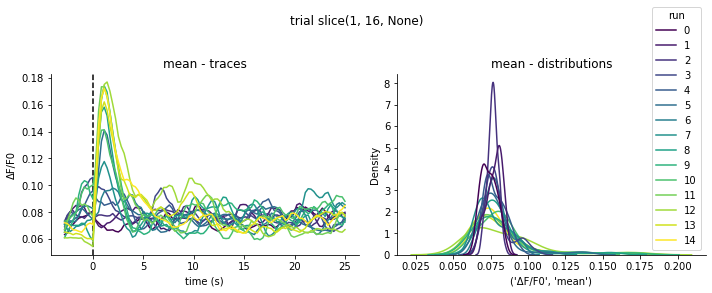

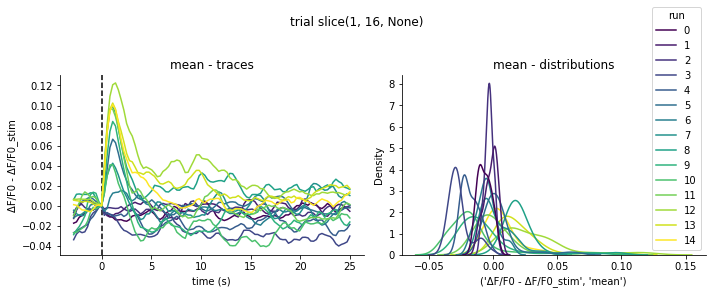

In [26]:
ykey_rel_postpro = f'{ykey_postpro} - {ykey_postpro}_stim'
for ykey in [ykey_postpro, ykey_rel_postpro]:
    figs[f'{ykey} aggregate traces'] = plot_aggregate_traces(
        xtimeseries, fps, ykey, hue=Label.RUN, itrial=slice(1, 16))

## Statistics (response metrics & cell classification)

### Create statistics dataframe

<span style="color:orange">NOTE: it is very important to use the info table generated from the suite2p output options "filelist" field as the basis to populate the dataframe. This ensures that the order of parsed parameters matches the order in which suite2p processed input files, and thus the order in which the fluorescence data is arranged.</span>

In [22]:
# Get the index dimensions of the fluorescence dataset
index_dims = {k: xtimeseries.index.unique(k) for k in xtimeseries.index.names}

# Create stats dataframes
logger.info('creating statistics dataframe')
stats = pd.DataFrame()

# Add information about pulse and time-average acoustic intensity to info table
output_info_table = add_intensity_to_table(output_info_table)

# Add experimental info to stats
if Label.P not in stats:
    logger.info('adding experimental info to stats...')
    exp_output_table = repeat_along_new_dims(
        output_info_table.drop(Label.NTRIALS, axis=1),
        {k: index_dims[k] for k in [Label.ROI, Label.TRIAL]})
    exp_output_table = exp_output_table.reorder_levels(
        [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
    stats = pd.concat([exp_output_table, stats], axis=1) 

# Add info about discarded trials
logger.info('adding "discarded" labels...')
stats[Label.DISCARDED] = False
stats.loc[pd.IndexSlice[:, :, ITRIALS_DISCARD], Label.DISCARDED] = True

logger.info('stats table:')
stats

 22/05/2022 18:02:32: creating statistics dataframe
 22/05/2022 18:02:32: deriving acoustic intensity information...
 22/05/2022 18:02:32: adding experimental info to stats...
 22/05/2022 18:02:32: adding "discarded" labels...
 22/05/2022 18:02:32: stats table:


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  \
ROI run trial                                                             
0   0   0      line3           100           0.2  3.56      0.0    50.0   
        1      line3           100           0.2  3.56      0.0    50.0   
        2      line3           100           0.2  3.56      0.0    50.0   
        3      line3           100           0.2  3.56      0.0    50.0   
        4      line3           100           0.2  3.56      0.0    50.0   
...              ...           ...           ...   ...      ...     ...   
448 14  11     line3           100           0.2  3.56      0.8    80.0   
        12     line3           100           0.2  3.56      0.8    80.0   
        13     line3           100           0.2  3.56      0.8    80.0   
        14     line3           100           0.2  3.56      0.8    80.0   
        15     line3           100           0.2  3.56      0.8    80.0   

               run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  discarded  
ROI run trial                                                     
0   0   0         869        0.000000         0.00000       True  
        1         869        0.000000         0.00000      False  
        2         869        0.000000         0.00000      False  
        3         869        0.000000         0.00000      False  
        4         869        0.000000         0.00000      False  
...               ...             ...             ...        ...  
448 14  11        863       19.784475        15.82758      False  
        12        863       19.784475        15.82758      False  
        13        863       19.784475        15.82758      False  
        14        863       19.784475        15.82758      False  
        15        863       19.784475        15.82758      False  

[107760 rows x 10 columns]

### Visualize run order (as processed by suite2p)

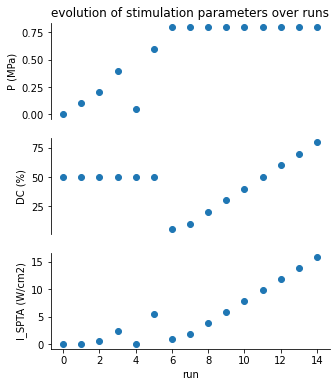

In [23]:
figs['protocol_summary'] = plot_protocol(
    output_info_table,
    xkey=Label.RUN,
    ykeys=(Label.P, Label.DC, Label.ISPTA))

### Identify & reject trials with significant stimulus-evoked motion artefact

 22/05/2022 18:02:32: computing diplacement velocity over time from registration offsets...
 22/05/2022 18:02:32: correcting displacement velocity at stimulus indexes to compensate for stimulus frames substitution...
 22/05/2022 18:02:33: identified 25 / 240 trials (10.4%) with peak displacement higher than 2.0 um/s


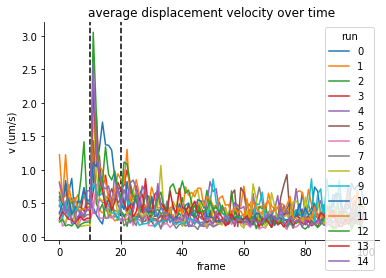

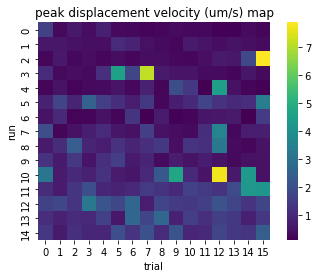

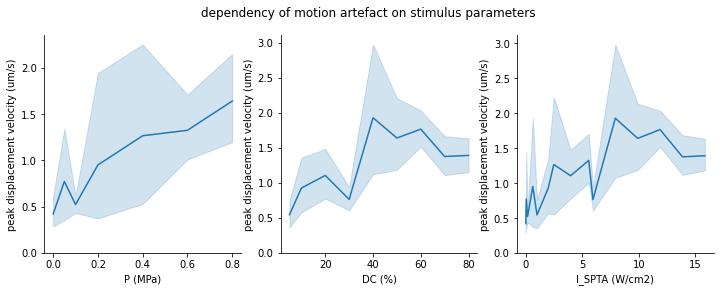

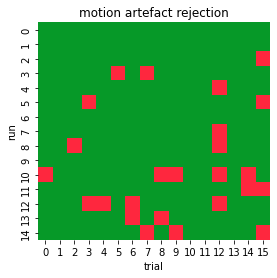

In [24]:
# Create (run, trial, frame) multi-index
exp_mux_keys = [Label.RUN, Label.TRIAL, Label.FRAME]
exp_mux = pd.MultiIndex.from_product(
    [index_dims[k] for k in exp_mux_keys], names=exp_mux_keys)

# Compute displacement velocity profiles
is_substituted = isinstance(si, StackInterpolator)
vdisp = compute_displacement_velocity(
    s2p_ops, exp_mux, 
    daq_settings['micronsPerPixel'],
    1 / daq_settings['framePeriod'],
    substituted=is_substituted)

# Plot average displacement velocity profile for each run
figs['vdisp_profiles'], ax = plt.subplots()
sns.despine(ax=ax)
ax.set_title('average displacement velocity over time')
for idx in [FrameIndex.STIM, FrameIndex.RESPONSE.stop]:
    ax.axvline(idx, c='k', ls='--')
sns.lineplot(
    data=vdisp.to_frame(), x=Label.FRAME, y=vdisp.name, ax=ax,
    hue=Label.RUN, ci=None, palette='tab10')

# Compute peak of displacement velocity within response window for each run and trial
# and assess of motion exceeded threshold
from constants import VDISP_THR
vdisp_window = vdisp.loc[pd.IndexSlice[:, :, FrameIndex.RESPONSE]]
vdisp_peaks = vdisp_window.groupby([Label.RUN, Label.TRIAL]).agg(
    find_response_peak).rename(Label.PEAK_DISP_VEL)
vdisp_peaks = vdisp_peaks.to_frame()
vdisp_peaks[Label.MOTION] = vdisp_peaks[Label.PEAK_DISP_VEL] > VDISP_THR
nmotion = vdisp_peaks[Label.MOTION].sum()
ntot = len(vdisp_peaks)

# Add peak displacement velocity and motion status info to stats
exp_vdisp_peaks = repeat_along_new_dim(
    vdisp_peaks, Label.ROI, stats.index.unique(Label.ROI)
    ).swaplevel(0, 2).swaplevel(1, 2).sort_index()
stats = pd.concat([stats, exp_vdisp_peaks], axis=1)

# Add stimulus parameters info to vdisp peaks dataframe
vdisp_peaks = pd.concat([vdisp_peaks, repeat_along_new_dim(
    output_info_table[[Label.P, Label.DC, Label.ISPTA]],
    Label.TRIAL, exp_mux.unique(level=Label.TRIAL))], axis=1)

# Plot peak displacement velocity heatmap
figs['peakvdisp_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(f'{Label.PEAK_DISP_VEL} map')
sns.heatmap(vdisp_peaks[Label.PEAK_DISP_VEL].unstack(), ax=ax, cmap=nan_viridis)

# Plot dependency of motion artefact on pressure & duty cycle 
figs['peakvdisp_vs_stimparams'], axes = plt.subplots(1, 3, figsize=(12, 4))
figs['peakvdisp_vs_stimparams'].suptitle('dependency of motion artefact on stimulus parameters')
for ax, xkey in zip(axes, [Label.P, Label.DC]):
    sns.lineplot(
        data=get_xdep_data(vdisp_peaks, xkey), x=xkey, y=Label.PEAK_DISP_VEL, ax=ax)
sns.lineplot(data=vdisp_peaks, x=Label.ISPTA, y=Label.PEAK_DISP_VEL, ax=axes[-1])
for ax in axes:
    sns.despine(ax=ax)
    ax.set_ylim(0, ax.get_ylim()[1])

# Plot motion artefact rejection heatmap
figs['motionreject_map'], ax = plt.subplots()
ax.set_title('motion artefact rejection')
ax.set_aspect(1.)
sns.heatmap(vdisp_peaks[Label.MOTION].unstack(), ax=ax, cmap=rdgn, cbar=False)

# Log identified motion trials
logger.info(
    f'identified {nmotion} / {ntot} trials ({nmotion / ntot * 1e2:.1f}%)'
    f' with peak displacement higher than {VDISP_THR} um/s')

### Visualize relative ΔF/F and Z(ΔF/F) traces across valid trials

 22/05/2022 18:02:34: identifying samples not without [discarded, motion] tags
 22/05/2022 18:02:34: adding expanded validity index to timeseries ...
 22/05/2022 18:02:38: filtering timeseries ...
 22/05/2022 18:02:41: adding time info to table...
 22/05/2022 18:02:43: adding time info to table...


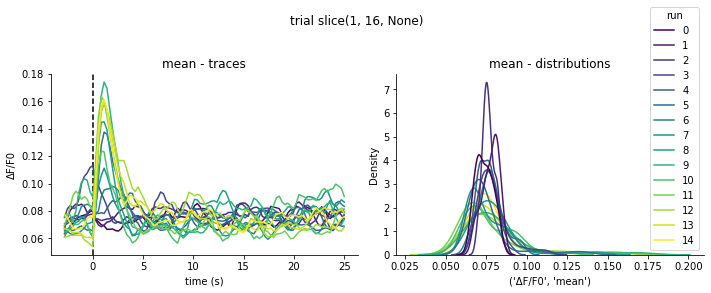

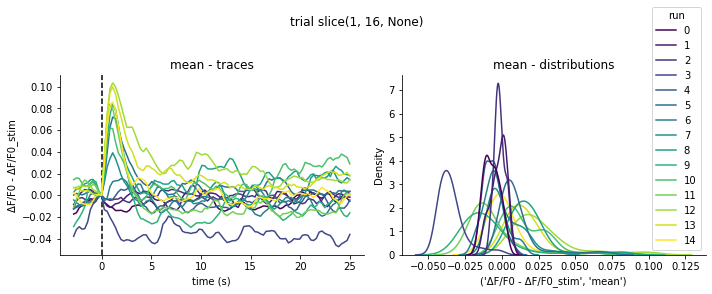

In [25]:
vtimeseries = valid_timeseries(xtimeseries, stats)
for ykey in [ykey_postpro, ykey_rel_postpro]:
    figs[f'{ykey} aggregate traces no motion'] = plot_aggregate_traces(
        vtimeseries, fps, ykey, hue=Label.RUN, itrial=slice(1, 16))

### Identify & reject trials with pre-stimulus activity

 22/05/2022 18:03:54: setting avg pre-stim ΔF/F0 - ΔF/F0_stim threshold to 0.100
 22/05/2022 18:03:54: analyzing avg pre-stim ΔF/F0 - ΔF/F0_stim levels...
 22/05/2022 18:03:55: identified 9937/107760 trials (9.2 %) with significant pre-stimulus activity
 22/05/2022 18:03:57: identified 0/240 trials (0.0%) with more than 50.0 % pre-active cells


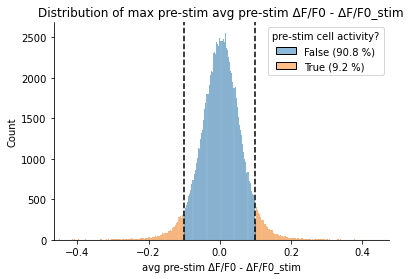

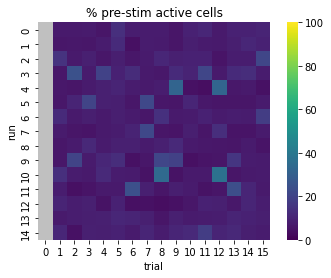

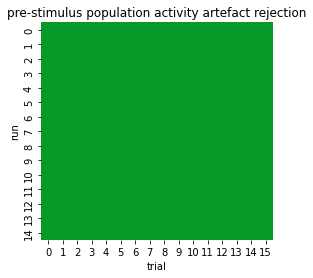

In [26]:
ykey_prestim_avg = f'avg pre-stim {ykey_rel_postpro}'
ythr_prestim = get_threshold_metric(ykey_postpro)
logger.info(f'setting {ykey_prestim_avg} threshold to {ythr_prestim:.3f}')

# Compute mean in pre-stimulus window for each trial
logger.info(f'analyzing {ykey_prestim_avg} levels...')
y_prestim = xtimeseries.loc[pd.IndexSlice[:, :, :, FrameIndex.PRESTIM], ykey_rel_postpro]
stats[ykey_prestim_avg] = y_prestim.groupby([Label.ROI, Label.RUN, Label.TRIAL]).mean()

# Classify pre-stimulus state on a per-ROI basis for each trial
stats[Label.PRESTIM_ACTIVITY] = stats[ykey_prestim_avg].abs() > ythr_prestim
npreacts, ntot = stats[Label.PRESTIM_ACTIVITY].sum(), len(stats)
pcts = {True: npreacts / ntot * 100, False: (ntot - npreacts) / ntot * 100}
logger.info(
    f'identified {npreacts}/{ntot} trials ({pcts[True]:.1f} %) with '
    'significant pre-stimulus activity')

# Plot histogram distribution of pre-stimulus dFF z-score
figs['prestim avg dist'], ax = plt.subplots()
sns.despine(ax=ax)
ax = sns.histplot(stats, x=ykey_prestim_avg, hue=Label.PRESTIM_ACTIVITY, ax=ax)
for sign in [-1, 1.]:
    ax.axvline(ythr_prestim * sign, ls='--', c='k')
mu, sigma = stats[ykey_prestim_avg].median(), stats[ykey_prestim_avg].std()
ax.set_xlim(mu - 7 * sigma, mu + 7 * sigma)
ax.set_title(f'Distribution of max pre-stim {ykey_prestim_avg}')
leg = ax.get_legend()
for t in leg.texts:
    cond = t.get_text() == 'True'
    t.set_text(f'{cond} ({pcts[cond]:.1f} %)')

# Compute and plot fraction of ROIs with pre-stimulus activity for each run & trial
nROIs = len(stats.index.unique(level=Label.ROI))
npreacts_per_run_trial = stats.loc[:, Label.PRESTIM_ACTIVITY].groupby(
    [Label.RUN, Label.TRIAL]).sum()
isdiscarded = stats[Label.DISCARDED].groupby([Label.RUN, Label.TRIAL]).first()
npreacts_per_run_trial.loc[isdiscarded[isdiscarded].index] = np.nan
pct_preacts_per_run_trial = (npreacts_per_run_trial / nROIs * 1e2).rename(Label.PCT_PREACTIVE_CELLS)
figs['pct_prestim_activity_map'], ax = plt.subplots()
ax.set_aspect(1.)
ax.set_title(Label.PCT_PREACTIVE_CELLS)
sns.heatmap(pct_preacts_per_run_trial.unstack(), ax=ax, vmin=0, vmax=100, cmap=nan_viridis)

# Label trials with large fraction of pre-active cells
from constants import PCT_PREACTIVE_THR
pop_preact_per_run_trial = (pct_preacts_per_run_trial > PCT_PREACTIVE_THR).rename(
    Label.PRESTIM_POP_ACTIVITY)
npreacts_pop, ntot = pop_preact_per_run_trial.sum(), len(pop_preact_per_run_trial)
pcts = {True: npreacts_pop / ntot * 100, False: (ntot - npreacts_pop) / ntot * 100}
logger.info(
    f'identified {npreacts_pop}/{ntot} trials ({pcts[True]:.1f}%)'
    f' with more than {PCT_PREACTIVE_THR} % pre-active cells')
exp_pop_preact_per_run_trial = repeat_along_new_dim(
    pop_preact_per_run_trial.to_frame(),
    Label.ROI, stats.index.unique(level=Label.ROI)).reorder_levels(
    [Label.ROI, Label.RUN, Label.TRIAL]).sort_index()
stats[Label.PRESTIM_POP_ACTIVITY] = exp_pop_preact_per_run_trial

# Plot pre-stimulus population activity rejection heatmap
figs['prestim reject map'], ax = plt.subplots()
ax.set_title('pre-stimulus population activity artefact rejection')
ax.set_aspect(1.)
sns.heatmap(pop_preact_per_run_trial.unstack(), ax=ax, cmap=rdgn, cbar=False);

### Visualize relative ΔF/F and Z(ΔF/F) traces across valid trials

 22/05/2022 18:04:04: identifying samples not without [discarded, motion, pre-stim cell activity?, pre-stim population activity?] tags
 22/05/2022 18:04:04: adding expanded validity index to timeseries ...
 22/05/2022 18:04:09: filtering timeseries ...
 22/05/2022 18:04:12: adding time info to table...
 22/05/2022 18:04:14: adding time info to table...


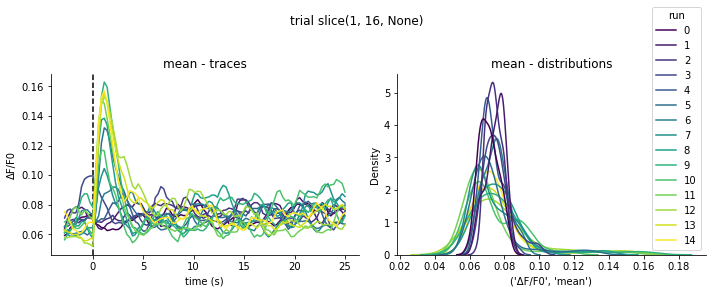

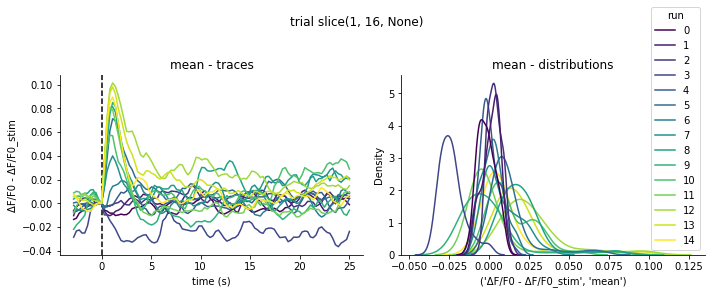

In [27]:
vtimeseries = valid_timeseries(xtimeseries, stats)
for ykey in [ykey_postpro, ykey_rel_postpro]:
    figs[f'{ykey} aggregate traces valid'] = plot_aggregate_traces(
        vtimeseries, fps, ykey, hue=Label.RUN, itrial=slice(1, 16))

### Compute average timeseries and states over valid trials

In [28]:
# Restrict timeseries to valid trials and average over trials
logger.info('computing trial-averaged timeseries per ROI & run, over valid trials...') 
trialavg_xtimeseries = vtimeseries.groupby([Label.ROI, Label.RUN, Label.FRAME]).agg({
    # DFF: just average
    Label.DFF: np.mean,
    Label.REL_DFF: np.mean,
    # z-score: average and rescale
    Label.ZSCORE: lambda s: s.mean() * np.sqrt(s.size),
    Label.REL_ZSCORE: lambda s: s.mean() * np.sqrt(s.size)
})

# Restrict stats to valid trials and average over them
logger.info('computing trial-averaged stats over valid trials...')
valid_stats = valid(stats)
trialavg_stats = get_trial_averaged(valid_stats)
trialavg_stats

 22/05/2022 18:04:48: computing trial-averaged timeseries per ROI & run, over valid trials...
 22/05/2022 18:06:02: computing trial-averaged stats over valid trials...
 22/05/2022 18:06:02: identifying samples not without [discarded, motion, pre-stim cell activity?, pre-stim population activity?] tags


line  trial_length  duration (s)   fps  P (MPa)  DC (%)  run ID  \
ROI run                                                                     
0   0    line3         100.0           0.2  3.56     0.00    50.0   869.0   
    1    line3         100.0           0.2  3.56     0.10    50.0   867.0   
    2    line3         100.0           0.2  3.56     0.20    50.0   866.0   
    3    line3         100.0           0.2  3.56     0.40    50.0   865.0   
    4    line3         100.0           0.2  3.56     0.05    50.0   868.0   
...        ...           ...           ...   ...      ...     ...     ...   
448 10   line3         100.0           0.2  3.56     0.80    40.0   856.0   
    11   line3         100.0           0.2  3.56     0.80    50.0   855.0   
    12   line3         100.0           0.2  3.56     0.80    60.0   861.0   
    13   line3         100.0           0.2  3.56     0.80    70.0   862.0   
    14   line3         100.0           0.2  3.56     0.80    80.0   863.0   

         I_SPPA (W/cm2)  I_SPTA (W/cm2)  peak displacement velocity (um/s)  \
ROI run                                                                      
0   0          0.000000        0.000000                           0.343438   
    1          0.309132        0.154566                           0.517614   
    2          1.236530        0.618265                           0.521290   
    3          4.946119        2.473059                           0.483075   
    4          0.077283        0.038642                           0.438421   
...                 ...             ...                                ...   
448 10        19.784475        7.913790                           0.796064   
    11        19.784475        9.892238                           1.289890   
    12        19.784475       11.870685                           1.496442   
    13        19.784475       13.849133                           1.247040   
    14        19.784475       15.827580                           1.221794   

         avg pre-stim ΔF/F0 - ΔF/F0_stim  
ROI run                                   
0   0                          -0.011853  
    1                          -0.007638  
    2                           0.007812  
    3                          -0.024845  
    4                           0.010114  
...                                  ...  
448 10                          0.022659  
    11                          0.010751  
    12                          0.024054  
    13                          0.011534  
    14                          0.022709  

[6735 rows x 11 columns]

### Visualize relative trial-averaged traces

 22/05/2022 18:06:15: adding time info to table...
 22/05/2022 18:06:15: adding time info to table...


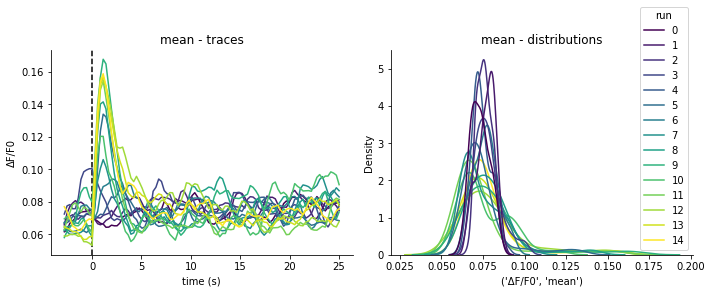

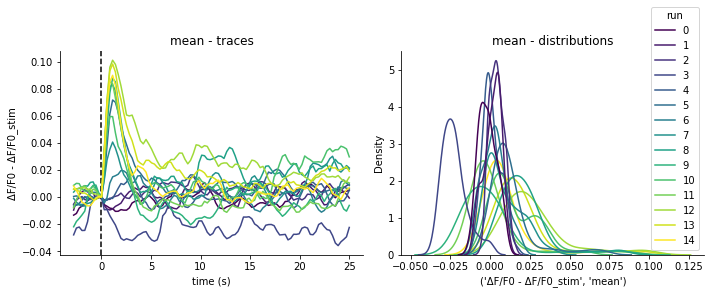

In [29]:
for ykey in [ykey_postpro, ykey_rel_postpro]:
    figs[f'{ykey} trial-averaged aggregate traces valid'] = plot_aggregate_traces(
        trialavg_xtimeseries, fps, ykey, hue=Label.RUN)

### Response type, pressure & duty cycle dependency

 22/05/2022 18:06:25: merging timeseries and stats information...
 22/05/2022 18:06:26: adding time info to table...
 22/05/2022 18:06:26: sub-indexing data...
 22/05/2022 18:06:26: filtering data...
 22/05/2022 18:06:26: cross-checking filters...
 22/05/2022 18:06:26: grouping by P (MPa), averaging and plotting mean ΔF/F0 - ΔF/F0_stim vs. time (s) ...
 22/05/2022 18:06:29: sub-indexing data...
 22/05/2022 18:06:29: filtering data...
 22/05/2022 18:06:29: cross-checking filters...
 22/05/2022 18:06:29: grouping by DC (%), averaging and plotting mean ΔF/F0 - ΔF/F0_stim vs. time (s) ...


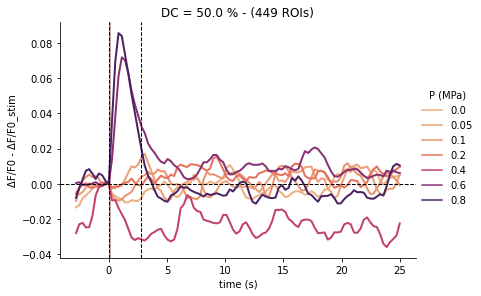

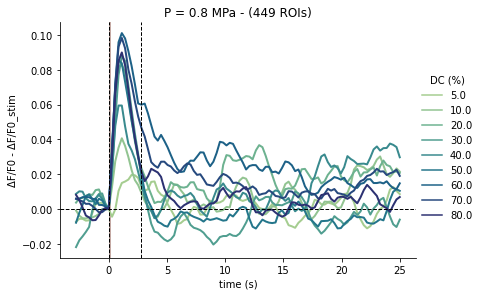

In [30]:
logger.info('merging timeseries and stats information...')
plt_data = trialavg_xtimeseries.copy()
expand_and_add(trialavg_stats, plt_data)
add_time_to_table(plt_data)
tracekwargs = dict(
    ci=None,
    yref=0.,
)
# Pressure dependency
figs[f'{ykey_rel_postpro} traces DC={DC_REF}%'] = plot_responses(
    plt_data, ykey=ykey_rel_postpro, DC=DC_REF, hue=Label.P, **tracekwargs)
# Duty cycle dependency
figs[f'{ykey_rel_postpro} traces P={P_REF}MPa'] = plot_responses(
    plt_data, ykey=ykey_rel_postpro, P=P_REF, hue=Label.DC, **tracekwargs)

### Assess response strength over ROIs and runs

 22/05/2022 18:07:06: applying <lambda> function on ΔF/F0 - ΔF/F0_stim in 10-20 index window across ROI, run ...
 22/05/2022 18:07:06: identified outputs in 6735/6735 windows (100.0 %)


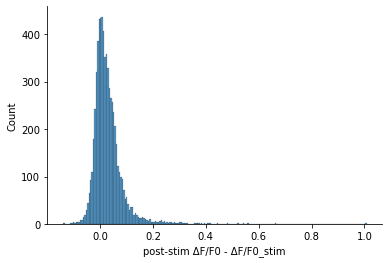

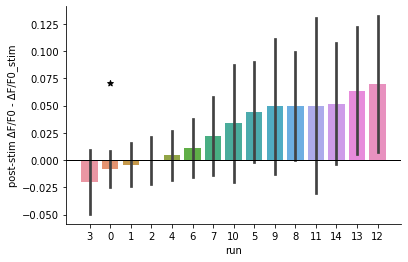

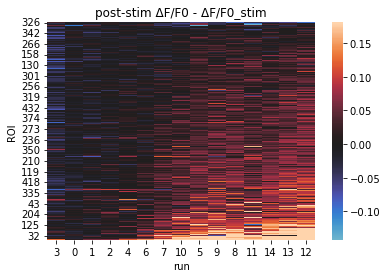

In [31]:
# Compute response strength average in response window for each ROI & run
ykey_poststim = f'post-stim {ykey_rel_postpro}'
trialavg_stats[ykey_poststim] = apply_in_window(
    lambda x: x.mean(), trialavg_xtimeseries, ykey_rel_postpro, FrameIndex.RESPONSE)

# Plot response strength histogram distributions
figs[f'{ykey_poststim} histogram'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(data=trialavg_stats, x=ykey_poststim)

# Order runs and ROIs by increasing response strength
run_order = trialavg_stats[ykey_poststim].groupby(
    Label.RUN).mean().sort_values().index
ROI_order = trialavg_stats[ykey_poststim].groupby(
    Label.ROI).mean().sort_values().index

# Plot response strength vs. run
figs[f'{ykey_poststim} vs run'], ax = plt.subplots()
sns.despine(ax=ax)
sns.barplot(
    ax=ax, data=trialavg_stats.reset_index(level=Label.RUN),
    x=Label.RUN, y=ykey_poststim, order=run_order, ci='sd')
# Add zero line
ax.axhline(0., c='k', lw=1)
# Add marker for zero-pressure run
irun_P0_ordered = run_order.values.tolist().index(irun_P0)
ax.scatter(irun_P0_ordered, .5 * ax.get_ylim()[1], marker='*', c='k')

# Plot response strength heatmap per ROI & run
figs[f'{ykey_poststim} map'], ax = plt.subplots()
ax.set_title(ykey_poststim)
med = trialavg_stats[ykey_poststim].median()
std = trialavg_stats[ykey_poststim].std()
sns.heatmap(
    trialavg_stats[ykey_poststim].unstack().reindex(
        ROI_order, axis=0).reindex(run_order, axis=1),
    center=0., ax=ax, vmax=med + 3 * std);


### Identify responding conditions for each cell 

 22/05/2022 18:07:22: identified 4254/6735 (63.16%) positive conditions across ROIs


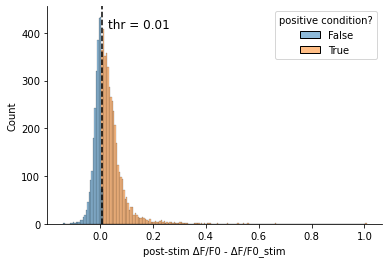

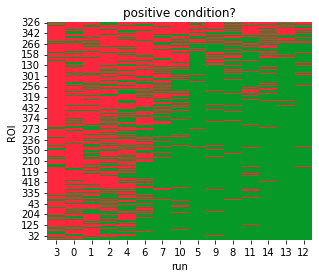

In [32]:
# For each ROI, threshold response strength to identify responsive conditions
ythr_poststim = get_threshold_metric(ykey_postpro, navg=ntrials_per_run)
trialavg_stats[Label.POS_COND] = trialavg_stats[ykey_poststim] > ythr_poststim
nposconds = trialavg_stats[Label.POS_COND].sum()
nconds = len(trialavg_stats)
logger.info(
    f'identified {nposconds}/{nconds} ({nposconds / nconds * 100:.2f}%) '
    'positive conditions across ROIs')

# Plot response strength histogram with condition type color code 
figs[f'{ykey_poststim} per condition type'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(data=trialavg_stats, x=ykey_poststim, hue=Label.POS_COND)
ax.axvline(ythr_poststim, c='k', ls='--')
ax.text(
    data_to_axis(ax, (ythr_poststim, 0))[0] + .02, .9, f'thr = {ythr_poststim:.2f}',
    transform=ax.transAxes, fontsize=12);

# Plot positive condition binary map per ROI & run
figs[f'{ykey_poststim} heatmap'], ax = plt.subplots(figsize=(4.75, 4))
ax.set_title(Label.POS_COND)
poscondsmap = trialavg_stats[Label.POS_COND].replace({True: 1., False: 0.}).unstack().reindex(
    ROI_order, axis=0).reindex(run_order, axis=1)
sns.heatmap(poscondsmap, ax=ax, cbar=False, cmap=gnrd);

### Identify responding cells based on their number of responsive conditions

 22/05/2022 18:07:28: identified 432/449 (96.2 %) responding cells


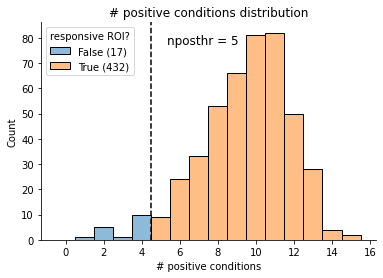

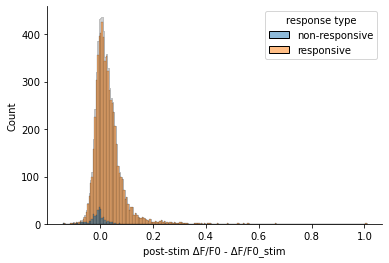

In [33]:
# Compute number of significant conditions per ROI
nposconds_per_roi = trialavg_stats[Label.POS_COND].groupby(Label.ROI).sum().rename(Label.NPOS_CONDS)
roistats = nposconds_per_roi.to_frame()

# Classify ROIs based on number of responsive conditions
from constants import NPOSCONDS_THR
roistats[Label.IS_RESP_ROI] = nposconds_per_roi >= NPOSCONDS_THR
roistats[Label.ROI_RESP_TYPE] = roistats[Label.IS_RESP_ROI].map(
    {True: 'responsive', False: 'non-responsive'})

# Add roistats to stats
expand_and_add(roistats, trialavg_stats)

# Log number and percentage of responding cells identified
ncells_per_cond = {k: sum(roistats[Label.IS_RESP_ROI] == k) for k in [True, False]}
nresp = ncells_per_cond[True]
ntot = len(roistats)
logger.info(f'identified {nresp}/{ntot} ({nresp / ntot * 100:.1f} %) responding cells')

# Plot histogram distribution of # responsive conditions per type
figs['nposconds histogram'], ax = plt.subplots()
ax.set_title(f'{Label.NPOS_CONDS} distribution')
sns.histplot(roistats, x=Label.NPOS_CONDS, bins=np.arange(nruns + 2) - 0.5, ax=ax,
             hue=Label.IS_RESP_ROI, hue_order=[False, True])
ax.axvline(NPOSCONDS_THR - 0.5, c='k', ls='--')
sns.despine(ax=ax)
leg = ax.get_legend()
for t in leg.texts:
    txt = t.get_text()
    b = txt == 'True'
    t.set_text(f'{txt} ({ncells_per_cond[b]})')
ax.text(
    data_to_axis(ax, (NPOSCONDS_THR, 0))[0] + .02, .9, f'nposthr = {NPOSCONDS_THR}',
    transform=ax.transAxes, fontsize=12)

# Plot response strength histogram with cell classification
figs[f'resp strength vs cell class'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    data=trialavg_stats, x=ykey_poststim, color='silver', element='step')
sns.histplot(
    data=trialavg_stats, x=ykey_poststim,
    hue=Label.ROI_RESP_TYPE, hue_order=get_default_rtypes());

### Save trial-averaged traces and stats to disk

In [34]:
postpro_line_dir = os.path.join(*split_path_at(postpro_outdir, mouseline)[:2])
trialavg_dir = get_output_equivalent(postpro_line_dir, 'processed', 'trial-averaged')
logger.info(f'saving trial-averaged stats and traces in {trialavg_dir} ...')
trialavg_stats.to_csv(os.path.join(trialavg_dir, f'stats_{mouseid}_{region}.csv'))
trialavg_xtimeseries.to_csv(os.path.join(trialavg_dir, f'timeseries_{mouseid}_{region}.csv'))

 22/05/2022 18:07:38: saving trial-averaged stats and traces in /Users/tlemaire/Documents/data/usnm/trial-averaged/kd_G0.5_V0.05_npad10/si_order0_npast2/w5.0s_q0.08/line3 ...


## Results visualization

### Spatial distribution of cells per response type

 22/05/2022 18:07:45: plotting cells map color-coded by response type...
 22/05/2022 18:07:45: extracting responses types per ROI...


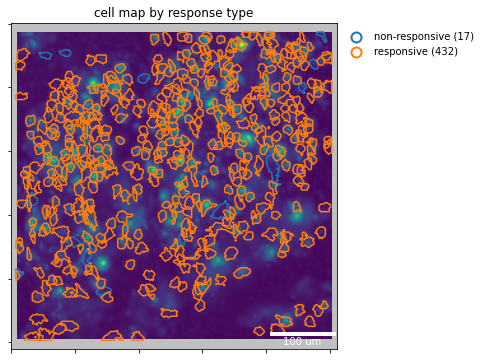

In [35]:
figs['cellmap'] = plot_cell_map(
    ROI_masks, trialavg_stats, s2p_ops, title='cell map by response type',
    um_per_px=daq_settings['micronsPerPixel'], refkey='Vcorr', mode='contour')

### Response strength dependency on cell response type

 22/05/2022 18:07:47: sub-indexing data...
 22/05/2022 18:07:47: filtering data...
 22/05/2022 18:07:47: cross-checking filters...
 22/05/2022 18:07:47: grouping by response type, averaging, estimating confidence intervals and plotting mean post-stim ΔF/F0 - ΔF/F0_stim vs. P (MPa) ...
 22/05/2022 18:07:47: sub-indexing data...
 22/05/2022 18:07:47: filtering data...
 22/05/2022 18:07:47: cross-checking filters...
 22/05/2022 18:07:47: grouping by response type, averaging, estimating confidence intervals and plotting mean post-stim ΔF/F0 - ΔF/F0_stim vs. DC (%) ...


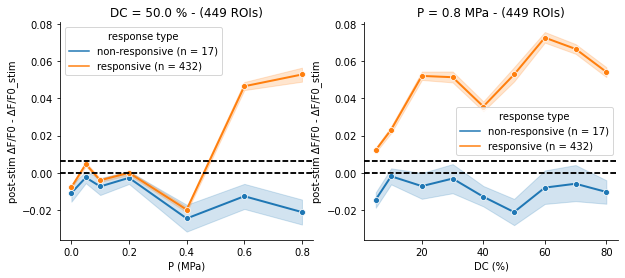

In [36]:
figs[f'{ykey_poststim} dependency'] = plot_stimparams_dependency_per_response_type(
    trialavg_stats, ykey_poststim, baseline=[0, ythr_poststim])

### Merge timeseries and stats into single dataframe

In [37]:
logger.info('merging timeseries and stats information...')
plt_data = trialavg_xtimeseries.copy()
expand_and_add(trialavg_stats, plt_data)
add_time_to_table(plt_data)
plt_data

 22/05/2022 18:08:21: merging timeseries and stats information...
 22/05/2022 18:08:22: adding time info to table...


ΔF/F0  ΔF/F0 - ΔF/F0_stim  Z(ΔF/F0)  \
ROI run frame                                           
0   0   0      0.084389           -0.014692  2.228359   
        1      0.074917           -0.024164  1.562786   
        2      0.082895           -0.016187  2.123321   
        3      0.072097           -0.026984  1.364634   
        4      0.074809           -0.024273  1.555155   
...                 ...                 ...       ...   
448 14  95     0.046393            0.015530 -0.134703   
        96     0.042000            0.011137 -0.466153   
        97     0.037139            0.006276 -0.832865   
        98     0.042456            0.011593 -0.431765   
        99     0.053073            0.022210  0.369236   

               Z(ΔF/F0) - Z(ΔF/F0)_stim   line  trial_length  duration (s)  \
ROI run frame                                                                
0   0   0                     -1.032321  line3         100.0           0.2   
        1                     -1.697894  line3         100.0           0.2   
        2                     -1.137360  line3         100.0           0.2   
        3                     -1.896047  line3         100.0           0.2   
        4                     -1.705525  line3         100.0           0.2   
...                                 ...    ...           ...           ...   
448 14  95                     1.171645  line3         100.0           0.2   
        96                     0.840195  line3         100.0           0.2   
        97                     0.473483  line3         100.0           0.2   
        98                     0.874584  line3         100.0           0.2   
        99                     1.675584  line3         100.0           0.2   

               P (MPa)  DC (%)  run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
ROI run frame                                                            
0   0   0          0.0    50.0   869.0        0.000000         0.00000   
        1          0.0    50.0   869.0        0.000000         0.00000   
        2          0.0    50.0   869.0        0.000000         0.00000   
        3          0.0    50.0   869.0        0.000000         0.00000   
        4          0.0    50.0   869.0        0.000000         0.00000   
...                ...     ...     ...             ...             ...   
448 14  95         0.8    80.0   863.0       19.784475        15.82758   
        96         0.8    80.0   863.0       19.784475        15.82758   
        97         0.8    80.0   863.0       19.784475        15.82758   
        98         0.8    80.0   863.0       19.784475        15.82758   
        99         0.8    80.0   863.0       19.784475        15.82758   

               peak displacement velocity (um/s)  \
ROI run frame                                      
0   0   0                               0.343438   
        1                               0.343438   
        2                               0.343438   
        3                               0.343438   
        4                               0.343438   
...                                          ...   
448 14  95                              1.221794   
        96                              1.221794   
        97                              1.221794   
        98                              1.221794   
        99                              1.221794   

               avg pre-stim ΔF/F0 - ΔF/F0_stim  post-stim ΔF/F0 - ΔF/F0_stim  \
ROI run frame                                                                  
0   0   0                            -0.011853                     -0.027759   
        1                            -0.011853                     -0.027759   
        2                            -0.011853                     -0.027759   
        3                            -0.011853                     -0.027759   
        4                            -0.011853                     -0.027759   
...                                        ...               

### Response type, pressure & duty cycle dependency, per category

 22/05/2022 18:08:24: sub-indexing data...
 22/05/2022 18:08:24: filtering data...
 22/05/2022 18:08:24: cross-checking filters...
 22/05/2022 18:08:24: grouping by response type, grouping by P (MPa), averaging and plotting mean ΔF/F0 - ΔF/F0_stim vs. time (s) ...
 22/05/2022 18:08:27: sub-indexing data...
 22/05/2022 18:08:27: filtering data...
 22/05/2022 18:08:27: cross-checking filters...
 22/05/2022 18:08:27: grouping by response type, grouping by DC (%), averaging and plotting mean ΔF/F0 - ΔF/F0_stim vs. time (s) ...


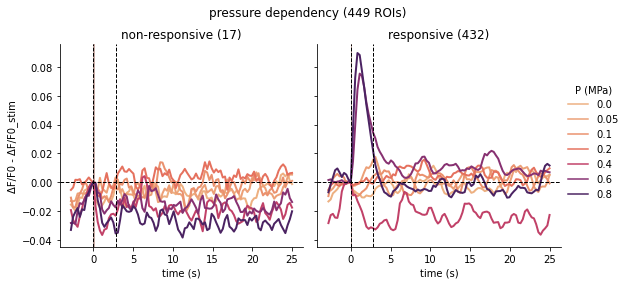

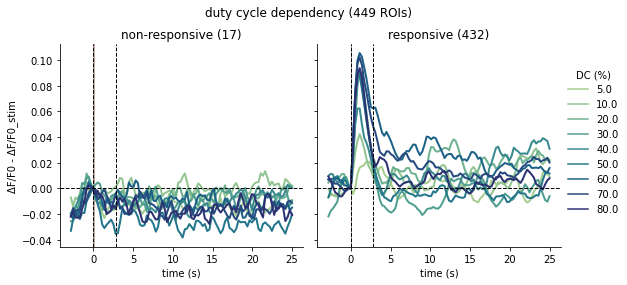

In [38]:
nROIs = len(trialavg_stats.index.unique(level=Label.ROI))
tracekwargs = dict(
    height = 4,  # height of each figure axis
    aspect = 1.,  # width / height aspect ratio of each axis
    hide_col_prefix = True,
    col_count_key = Label.ROI,
    ci=None,
    yref=0.
)
# Pressure dependency
figs[f'{ykey_rel_postpro} traces by type DC={DC_REF}%'] = plot_responses(
    plt_data, ykey=ykey_rel_postpro, DC=DC_REF, hue=Label.P, 
    col=Label.ROI_RESP_TYPE, title=f'pressure dependency ({nROIs} ROIs)', **tracekwargs)
# Duty cycle dependency
figs[f'{ykey_rel_postpro} traces by type P={P_REF}MPa'] = plot_responses(
    plt_data, ykey=ykey_rel_postpro, P=P_REF, hue=Label.DC, 
    col=Label.ROI_RESP_TYPE, title=f'duty cycle dependency ({nROIs} ROIs)', **tracekwargs)

### Save figures

In [39]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, prefix=figsprefix)

# Save stacks as GIFs if specified
if irun_inspect is not None and save_gifs:
    #raw and fileted stacks from specific run
    save_stack_to_gif(
        figsdir, {'raw': raw_stack_fpaths[irun_inspect], 'filtered': filtered_stack_fpaths[irun_inspect]},
        ilabels=i_stim_frames_run)
    # registered stack (slice corresponding to specific run)
    save_stack_to_gif(
        figsdir, s2p_ops, title=outstack_label,
        ilabels=istimframes_stacked, bounds=runbounds)

 20/05/2022 17:28:10: saving figure "dataset_info" on page 0
 20/05/2022 17:28:10: saving figure "trialavg_stackavg_traces raw" on page 1
 20/05/2022 17:28:10: saving figure "trialavg_stackavg_traces substituted" on page 2
 20/05/2022 17:28:10: saving figure "trialavg_stackavg_traces filtered" on page 3
 20/05/2022 17:28:10: saving figure "registered_offsets" on page 4
 20/05/2022 17:28:11: saving figure "phasecorrpeak_over_time" on page 5
 20/05/2022 17:28:11: saving figure "PCdrifts" on page 6
 20/05/2022 17:28:11: saving figure "registered_images" on page 7
 20/05/2022 17:28:11: saving figure "sparse_maps" on page 8
 20/05/2022 17:28:11: saving figure "identified_ROIs" on page 9
 20/05/2022 17:28:12: saving figure "ROI_prob_dists" on page 10
 20/05/2022 17:28:12: saving figure "ΔF/F0 aggregate traces" on page 11
 20/05/2022 17:28:12: saving figure "ΔF/F0 - ΔF/F0_stim aggregate traces" on page 12
 20/05/2022 17:28:12: saving figure "protocol_summary" on page 13
 20/05/2022 17:28:12: 

### Notify upon completion

In [40]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseid} {region} notebook completed in {tstamp_end - tstamp_start} s'
if not no_slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 20/05/2022 17:28:19: mouse12 region1 notebook completed in 0:02:52.858001 s
